In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [233]:
# Input Paths
BASE_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/features/')
#TRAIN_FEATURE_PATH = BASE_PATH.joinpath('Xception_train_11_12_19_features.csv')
#TRAIN_FEATURE_PATH = BASE_PATH.joinpath('Xception_1820_N_features.csv')
TRAIN_FEATURE_PATH = BASE_PATH.joinpath('Xception_train_13_12_19_test_features.csv')
VAL_FEATURE_PATH = BASE_PATH.joinpath('Xception_1794_T_norm_features.csv')

In [234]:
# Read in training and validation data
train_features = pd.read_csv(TRAIN_FEATURE_PATH)
print(train_features.shape)
val_features = pd.read_csv(VAL_FEATURE_PATH)
print(val_features.shape)

(9780, 2050)
(1745, 2050)


In [235]:
train_features.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0,0.0,1.639567,0.000000,0.0,0.0,0.000000,0.164911,0.0,0.000000,...,0.130256,0.104632,0.0,0.0,0.000000,0.0,0.0,0.542198,0.0,cancer
1,1,0.0,1.877161,0.179322,0.0,0.0,0.000000,0.046880,0.0,0.000000,...,0.088118,0.217262,0.0,0.0,0.000000,0.0,0.0,3.103851,0.0,cancer
2,2,0.0,3.863373,1.074873,0.0,0.0,0.027921,0.390105,0.0,0.000000,...,0.325119,0.388982,0.0,0.0,0.003159,0.0,0.0,1.956014,0.0,cancer
3,3,0.0,1.977032,4.670845,0.0,0.0,0.000000,0.189062,0.0,1.679509,...,0.441962,0.387150,0.0,0.0,0.000000,0.0,0.0,4.168045,0.0,cancer
4,4,0.0,1.682263,8.293345,0.0,0.0,0.000000,0.393497,0.0,1.500764,...,1.291881,0.715731,0.0,0.0,0.000000,0.0,0.0,8.654212,0.0,cancer


In [236]:
train_features.tail()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
9775,9775,0.0,0.996751,0.000000,0.0,0.0,0.000000,0.006561,0.0,0.000000,...,0.154572,0.425095,0.0,0.0,0.0,0.0,0.0,1.555641,0.0,non-cancer
9776,9776,0.0,1.069691,0.000000,0.0,0.0,0.097388,0.006034,0.0,0.000000,...,0.217477,0.652633,0.0,0.0,0.0,0.0,0.0,0.145479,0.0,non-cancer
9777,9777,0.0,0.874811,0.077687,0.0,0.0,0.000000,0.339557,0.0,0.000000,...,0.045509,1.452608,0.0,0.0,0.0,0.0,0.0,0.326469,0.0,non-cancer
9778,9778,0.0,0.800376,0.179731,0.0,0.0,0.000000,0.014677,0.0,0.000000,...,0.000000,0.002114,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,non-cancer
9779,9779,0.0,2.366340,1.848995,0.0,0.0,0.000000,0.364747,0.0,0.164084,...,0.369565,0.290079,0.0,0.0,0.0,0.0,0.0,0.357932,0.0,non-cancer


In [237]:
val_features.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0,0.0,5.178304,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0000,0.578885,0.0,0.0,0.0,0.0,0.0,2.376188,0.000000,cancer
1,1,0.0,9.520402,1.805828,0.0,0.0,0.0,0.486806,0.0,0.000000,...,0.0000,0.129519,0.0,0.0,0.0,0.0,0.0,10.594058,0.000000,cancer
2,2,0.0,6.183286,0.032064,0.0,0.0,0.0,0.165765,0.0,0.000000,...,0.0115,0.881420,0.0,0.0,0.0,0.0,0.0,6.490275,0.018556,cancer
3,3,0.0,5.626123,1.636648,0.0,0.0,0.0,0.675921,0.0,0.154458,...,0.0000,0.560829,0.0,0.0,0.0,0.0,0.0,9.241981,0.000000,cancer
4,4,0.0,1.919629,0.456309,0.0,0.0,0.0,2.633804,0.0,0.041366,...,0.0000,0.941436,0.0,0.0,0.0,0.0,0.0,2.093502,0.000000,cancer


In [238]:
train_features = train_features.drop('Unnamed: 0', axis = 'columns')
val_features = val_features.drop('Unnamed: 0', axis = 'columns')

In [239]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.0,1.639567,0.000000,0.0,0.0,0.000000,0.164911,0.0,0.000000,0.0,...,0.130256,0.104632,0.0,0.0,0.000000,0.0,0.0,0.542198,0.0,cancer
1,0.0,1.877161,0.179322,0.0,0.0,0.000000,0.046880,0.0,0.000000,0.0,...,0.088118,0.217262,0.0,0.0,0.000000,0.0,0.0,3.103851,0.0,cancer
2,0.0,3.863373,1.074873,0.0,0.0,0.027921,0.390105,0.0,0.000000,0.0,...,0.325119,0.388982,0.0,0.0,0.003159,0.0,0.0,1.956014,0.0,cancer
3,0.0,1.977032,4.670845,0.0,0.0,0.000000,0.189062,0.0,1.679509,0.0,...,0.441962,0.387150,0.0,0.0,0.000000,0.0,0.0,4.168045,0.0,cancer
4,0.0,1.682263,8.293345,0.0,0.0,0.000000,0.393497,0.0,1.500764,0.0,...,1.291881,0.715731,0.0,0.0,0.000000,0.0,0.0,8.654212,0.0,cancer


In [240]:
train_features = train_features.replace('normal', 'non-cancer')
non_cancer_features = train_features.loc[train_features['label'] == 'non-cancer']
#non_cancer_features = train_features.loc[train_features['label'] == 'normal']
non_cancer_features = non_cancer_features.iloc[:,:]
non_cancer_features.shape

(5876, 2049)

In [241]:
len(non_cancer_features)

5876

In [242]:
cancer_features = train_features.loc[train_features['label'] == 'cancer']
cancer_features.shape

(3904, 2049)

In [243]:
def balance_features(cancer_features, non_cancer_features):
    cancer_tiles, non_cancer_tiles = len(cancer_features), len(non_cancer_features)
    balanced_tile_num = min(cancer_tiles, non_cancer_tiles)
    cancer_features = cancer_features.iloc[:balanced_tile_num, :]
    non_cancer_features = non_cancer_features.iloc[:balanced_tile_num, :]
    return cancer_features, non_cancer_features

# cancer_features_balanced, non_cancer_features_balanced = balance_features(cancer_features, non_cancer_features)
# print('cancer features shape: {0}'.format(cancer_features_balanced.shape))
# print('non-cancer features shape: {0}'.format(non_cancer_features_balanced.shape))

In [244]:
all_train_features = pd.concat([non_cancer_features, cancer_features], axis = 0)

In [245]:
all_train_features

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
3904,0.0,2.771610,0.012813,0.0,0.0,0.000000,0.060352,0.0,0.000000,0.0,...,0.358530,0.420825,0.004958,0.0,0.000000,0.000000,0.0,1.737176,0.000000,non-cancer
3905,0.0,0.071683,0.925452,0.0,0.0,0.510645,0.054982,0.0,0.000000,0.0,...,0.000000,0.005662,0.000000,0.0,0.000000,0.000000,0.0,0.229622,0.000000,non-cancer
3906,0.0,3.191644,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.001443,0.0,...,0.046983,1.987848,0.000000,0.0,0.000000,0.000000,0.0,1.508143,0.000000,non-cancer
3907,0.0,6.183749,7.004557,0.0,0.0,0.823746,0.913585,0.0,4.376864,0.0,...,0.095984,1.979556,0.000000,0.0,0.000000,0.035481,0.0,4.948020,0.000000,non-cancer
3908,0.0,0.090273,1.306299,0.0,0.0,0.370439,0.000000,0.0,0.000000,0.0,...,0.136666,0.052539,0.000000,0.0,0.000000,0.000000,0.0,0.023531,0.000000,non-cancer
3909,0.0,0.731515,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.064599,0.100305,0.000000,0.0,0.000000,0.000000,0.0,0.750640,0.000000,non-cancer
3910,0.0,0.604014,0.000000,0.0,0.0,0.000000,0.254885,0.0,0.000000,0.0,...,0.000000,1.343909,0.000000,0.0,0.024858,0.000000,0.0,0.190881,0.000000,non-cancer
3911,0.0,0.214640,0.000000,0.0,0.0,0.013590,0.000000,0.0,0.000000,0.0,...,0.028264,0.051945,0.000000,0.0,0.000000,0.000000,0.0,0.144217,0.000000,non-cancer
3912,0.0,0.402361,0.083973,0.0,0.0,1.238696,0.077752,0.0,0.000000,0.0,...,0.000000,0.010333,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,non-cancer
3913,0.0,4.129584,0.022811,0.0,0.0,0.000000,0.040640,0.0,0.000000,0.0,...,0.395358,0.654863,0.000000,0.0,0.000000,0.000000,0.0,0.502068,0.000000,non-cancer


In [246]:
all_train_features = all_train_features.sample(frac=1)

In [247]:
all_train_features

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
4240,0.0,0.828740,0.000000,0.0,0.0,0.000000,0.234961,0.0,0.000000,0.00000,...,0.421035,0.886552,0.0,0.0,0.000000,0.000000,0.0,0.484346,0.000000,non-cancer
2328,0.0,4.181090,5.390736,0.0,0.0,0.000000,1.688400,0.0,0.445439,0.00000,...,0.000000,0.004008,0.0,0.0,0.000000,0.000000,0.0,4.845373,0.000000,cancer
7069,0.0,0.053731,0.625581,0.0,0.0,0.000000,0.017235,0.0,0.000000,0.00000,...,0.024583,0.133535,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,non-cancer
4348,0.0,0.846094,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,...,0.042581,0.523617,0.0,0.0,0.000000,0.000000,0.0,0.364216,0.000000,non-cancer
385,0.0,1.304173,0.000000,0.0,0.0,0.096775,0.074835,0.0,0.000000,0.00000,...,0.228394,0.168155,0.0,0.0,0.000000,0.000000,0.0,0.656747,0.000000,cancer
5747,0.0,1.034327,0.122021,0.0,0.0,0.000000,0.073670,0.0,0.000000,0.00000,...,0.280510,0.925285,0.0,0.0,0.000000,0.000000,0.0,0.135419,0.000000,non-cancer
5685,0.0,1.116895,0.000000,0.0,0.0,0.000000,0.463686,0.0,0.000000,0.00000,...,0.489803,1.103836,0.0,0.0,0.081671,0.000000,0.0,0.258807,0.000000,non-cancer
4852,0.0,2.836762,0.000000,0.0,0.0,0.023248,0.152463,0.0,0.000000,0.00000,...,0.006337,0.591061,0.0,0.0,0.006278,0.000000,0.0,2.565669,0.000000,non-cancer
852,0.0,5.672940,0.000000,0.0,0.0,0.000000,0.088405,0.0,0.000000,0.00000,...,0.070630,0.737435,0.0,0.0,0.000000,0.000000,0.0,3.251910,0.000000,cancer
5390,0.0,1.046075,0.000000,0.0,0.0,0.000000,0.043507,0.0,0.000000,0.00000,...,0.028652,1.325343,0.0,0.0,0.000000,0.000000,0.0,5.666920,0.000000,non-cancer


In [248]:
val_features.tail()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
1740,0.0,0.127312,0.741941,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.375875,0.184100,0.0,0.0,0.0,0.0,0.0,0.288014,0.0,non-cancer
1741,0.0,2.927642,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.481739,0.0,0.0,0.0,0.0,0.0,2.662938,0.0,non-cancer
1742,0.0,2.863394,0.039675,0.0,0.0,0.014402,0.000000,0.0,0.0,0.0,...,0.154859,0.631619,0.0,0.0,0.0,0.0,0.0,2.930571,0.0,non-cancer
1743,0.0,6.087877,0.000000,0.0,0.0,0.000000,0.233228,0.0,0.0,0.0,...,0.032534,0.312665,0.0,0.0,0.0,0.0,0.0,4.347494,0.0,non-cancer
1744,0.0,5.700473,2.163318,0.0,0.0,0.045864,0.179462,0.0,0.0,0.0,...,0.102501,1.221430,0.0,0.0,0.0,0.0,0.0,1.273008,0.0,non-cancer


In [249]:
val_features = val_features.replace('normal', 'non-cancer')

In [250]:
#Balance cancer and non-cancer features in validation set with subsampling
non_cancer_val_features = val_features.loc[val_features['label'] == 'non-cancer']
cancer_val_features = val_features.loc[val_features['label'] == 'cancer']

print('cancer features shape: {0}'.format(cancer_val_features.shape))
print('non-cancer features shape: {0}'.format(non_cancer_val_features.shape))

cancer_val_features_balanced, non_cancer_val_features_balanced = balance_features(cancer_val_features, non_cancer_val_features)

print('cancer features shape: {0}'.format(cancer_val_features_balanced.shape))
print('non-cancer features shape: {0}'.format(non_cancer_val_features_balanced.shape))

cancer features shape: (1021, 2049)
non-cancer features shape: (724, 2049)
cancer features shape: (724, 2049)
non-cancer features shape: (724, 2049)


In [251]:
val_balanced_features = pd.concat([cancer_val_features_balanced, non_cancer_val_features_balanced], axis = 0)

In [252]:
val_balanced_features.shape

(1448, 2049)

In [253]:
train_labels = all_train_features['label']
val_labels = val_balanced_features['label']

In [254]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(train_labels)
Y_val = lb.transform(val_labels)

In [255]:
np.unique(Y_train, return_counts = True)

(array([0, 1]), array([3904, 5876]))

In [256]:
np.unique(Y_val)

array([0, 1])

In [257]:
X_train = np.array(all_train_features.drop('label', axis = 'columns'))
X_val = np.array(val_balanced_features.drop('label', axis = 'columns'))

In [258]:
X_val.shape

(1448, 2048)

In [259]:
#X_train = np.transpose(X_train)
#X_val = np.transpose(X_val)

In [260]:
scaler = StandardScaler().fit(X_train)
#scaler = MinMaxScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
print(X_train_norm.shape)

(9780, 2048)


In [261]:
X_val_norm = scaler.transform(X_val)
#X_val_norm = StandardScaler().fit_transform(X_val)

In [262]:
X_val_norm.shape

(1448, 2048)

In [263]:

#X_train_norm = np.transpose(X_train_norm)
#X_val_norm = np.transpose(X_val_norm)

0.8695740538126262
0.01704577627611021


(array([1.373e+03, 3.000e+01, 1.400e+01, 8.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.14422989,  0.49847467,  1.14117923,  1.7838838 ,  2.42658836,
         3.06929292,  3.71199749,  4.35470205,  4.99740661,  5.64011118,
         6.28281574,  6.9255203 ,  7.56822487,  8.21092943,  8.85363399,
         9.49633855, 10.13904312, 10.78174768, 11.42445224, 12.06715681,
        12.70986137]),
 <a list of 20 Patch objects>)

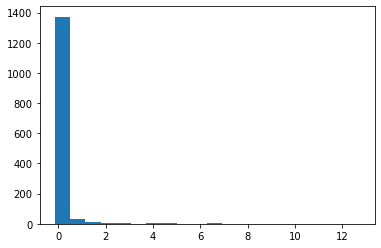

In [264]:
VAL_NUM = 8
print(X_val_norm[:,VAL_NUM].std())
print(X_val_norm[:,VAL_NUM].mean())
plt.hist(X_val_norm[:,VAL_NUM], bins = 20)

In [265]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state = 42)

In [266]:
#random_array = np.round(np.random.rand(8)).astype(np.uint8)

In [267]:
model = Sequential()
#model.add(Dense(1536, input_shape=(1536,), activation = 'relu'))
#model.add(Dense(2048, input_shape=(2048,), activation = 'relu', kernel_regularizer = l2(0.01)))
model.add(Dense(2048, input_shape=(2048,), activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'] )

In [268]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_63 (Dense)             (None, 32)                65568     
_________________________________________________________________
dense_64 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 33        
Total params: 4,263,009
Trainable params: 4,263,009
Non-trainable params: 0
_________________________________________________________________


In [269]:
history = model.fit(X_train_norm, Y_train, validation_data=(X_val_norm, Y_val), epochs = 50, batch_size = 600)

Train on 9780 samples, validate on 1448 samples
Epoch 1/50
9780/9780 [==============================] - 2s 187us/step - loss: 0.5108 - acc: 0.7537 - val_loss: 0.5199 - val_acc: 0.7493
Epoch 2/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.3465 - acc: 0.8530 - val_loss: 0.6764 - val_acc: 0.6975
Epoch 3/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.2689 - acc: 0.8936 - val_loss: 0.6941 - val_acc: 0.6851
Epoch 4/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.2077 - acc: 0.9200 - val_loss: 0.7326 - val_acc: 0.6775
Epoch 5/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.1546 - acc: 0.9439 - val_loss: 0.8368 - val_acc: 0.6927
Epoch 6/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.1174 - acc: 0.9641 - val_loss: 0.9210 - val_acc: 0.6968
Epoch 7/50
9780/9780 [==============================] - 1s 74us/step - loss: 0.0834 - acc: 0.9756 - val_loss: 0.9692 - val_acc: 0.7003
Epoch 

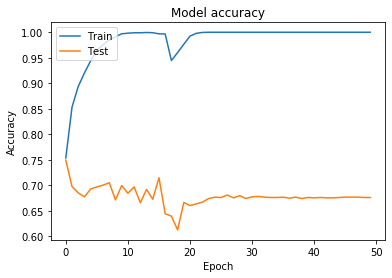

In [270]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

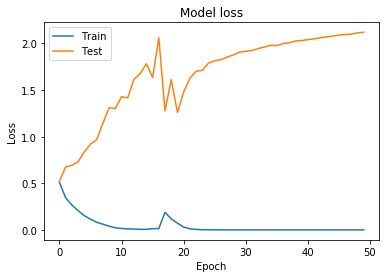

In [271]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [218]:
val_loss, val_acc = model.evaluate(X_val_norm, Y_val)
print('Loss: {0} Acc: {1}'.format(val_loss, val_acc))

1448/1448 [==============================] - 0s 62us/step
Loss: 2.077128893570352 Acc: 0.7472375690607734


In [219]:
np.unique(Y_train, return_counts = True)

(array([0, 1]), array([2979, 3315]))

(array([2979.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3315.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

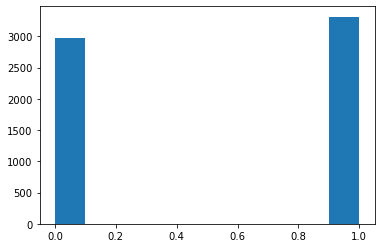

In [220]:
train_sigmoid = model.predict(X_train_norm)
plt.hist(train_sigmoid)

In [221]:
lb.transform(['cancer'])

array([[0]])

In [222]:
np.unique(Y_val, return_counts = True)

(array([0, 1]), array([724, 724]))

In [223]:
1024/724

1.4143646408839778

In [224]:
val_sigmoid = model.predict(X_val_norm)

(array([972.,  23.,  17.,  10.,  12.,  16.,   7.,  13.,  31., 347.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

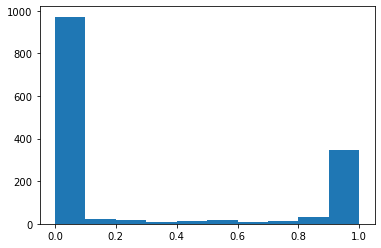

In [225]:
plt.hist(val_sigmoid)

In [226]:
np.sum(val_sigmoid > 0.5)

414

In [227]:
def plot_confusion_matrix(cm, classes=None):
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 300)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

In [228]:
Y_val[::-1]

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [229]:
np.invert(Y_val.astype(np.bool)).astype(np.int64)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [230]:
val_sigmoid > 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [231]:
cm = confusion_matrix(Y_val, (val_sigmoid > 0.5).astype(np.int64))
cm

array([[696,  28],
       [338, 386]])

[[0.96132597 0.03867403]
 [0.46685083 0.53314917]]


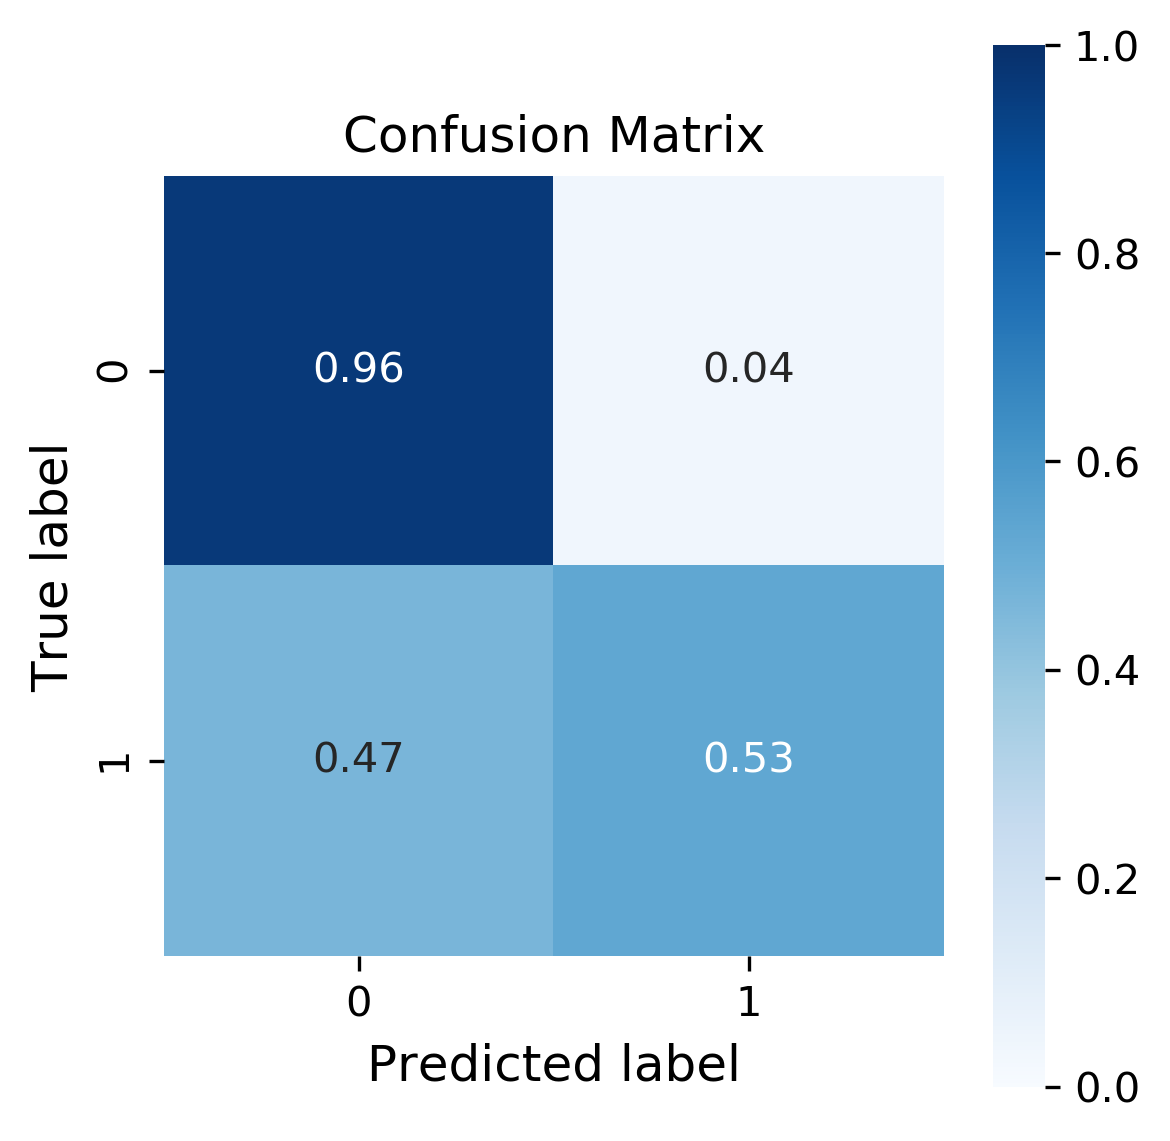

In [232]:
plot_confusion_matrix(cm)